<a href="https://colab.research.google.com/github/saurabkunwar/computervision/blob/main/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Project

Project that detects picture of 101 categories of food. 

## Loading data

In [ ]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101",
          split=["train", "validation"],
          shuffle_files=True,
          as_supervised=True,
          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteCNP5UG/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteCNP5UG/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Visualizing the data

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

(512, 512, 3) 

23


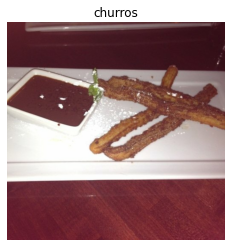

In [ ]:
import matplotlib.pyplot as plt

sample_data = train_data.take(1)

for image, label in sample_data:
  print(f"{image.shape} \n")
  print(label.numpy())
  plt.figure()
  plt.imshow(image)
  plt.axis(False)
  plt.title(class_names[label.numpy()])


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

Visualizing more images

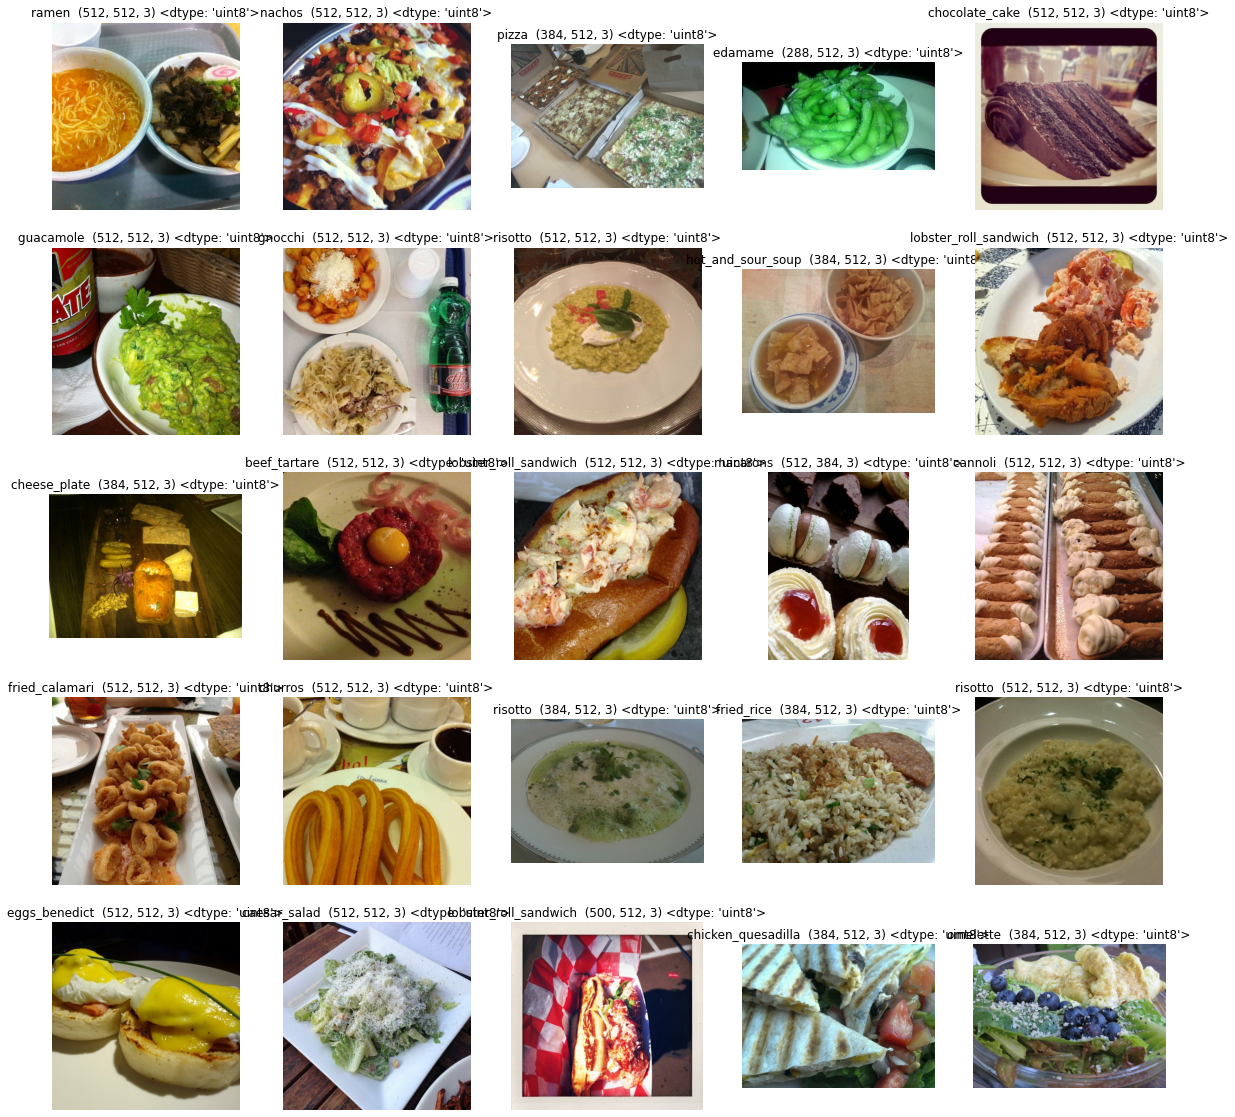

In [ ]:
random_data = train_data.take(25)

plt.figure(figsize=(20, 20))

i = 1

for image, label in random_data:
  plt.subplot(5, 5, i)
  plt.imshow(image)
  plt.axis(False)
  plt.title(f"{class_names[label.numpy()]}  {image.shape} {image.dtype}")
  i=i+1

## Preprocessing images

In [ ]:
import tensorflow as tf

In [ ]:
def preprocess_img(image, label):

  image = tf.image.resize(image, [224, 224])
  return tf.cast(image, tf.float32), label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.map(preprocess_img, AUTOTUNE).shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.map(preprocess_img, AUTOTUNE).shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Designing and fitting feature extraction model

In [ ]:
from tensorflow.keras import layers

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Creating callback
callback_path = "checkpoint/cp.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(callback_path,
                                                               monitor="val_acc",
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               verbose=1)

In [ ]:
initial_epochs = 5
history_feature_extraction = model.fit(train_data,
                                       epochs=initial_epochs,
                                       validation_data=test_data,
                                       validation_steps=int(0.25 * len(test_data)),
                                       callbacks=[model_checkpoint_callback])

Epoch 1/5
2368/2368 [==============================] - 361s 136ms/step - loss: 1.8228 - accuracy: 0.5589 - val_loss: 1.2193 - val_accuracy: 0.6786


Epoch 2/5
2368/2368 [==============================] - 318s 133ms/step - loss: 1.2947 - accuracy: 0.6661 - val_loss: 1.1255 - val_accuracy: 0.7003


Epoch 3/5
2368/2368 [==============================] - 319s 134ms/step - loss: 1.1437 - accuracy: 0.7023 - val_loss: 1.0747 - val_accuracy: 0.7135


Epoch 4/5
2368/2368 [==============================] - 318s 133ms/step - loss: 1.0460 - accuracy: 0.7270 - val_loss: 1.0770 - val_accuracy: 0.7099


Epoch 5/5
2368/2368 [==============================] - 317s 133ms/step - loss: 0.9739 - accuracy: 0.7434 - val_loss: 1.0784 - val_accuracy: 0.7070


In [ ]:
model.save("food_vision")

INFO:tensorflow:Assets written to: food_vision/assets


INFO:tensorflow:Assets written to: food_vision/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Fine tuning the model

In [ ]:
base_model.trainable = True

for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_3 True
rescaling_1 True
normalization_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True


In [ ]:
# Callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
feature_epochs = initial_epochs + 100

history_fine_tuning = model.fit(train_data,
                                epochs=feature_epochs,
                                initial_epoch=history_feature_extraction.epoch[-1],
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(train_data)),
                                callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 5/105
2368/2368 [==============================] - 1504s 629ms/step - loss: 0.8532 - accuracy: 0.7680 - val_loss: 0.8538 - val_accuracy: 0.7637
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/105
2368/2368 [==============================] - 1484s 626ms/step - loss: 0.5243 - accuracy: 0.8541 - val_loss: 0.8355 - val_accuracy: 0.7763
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/105
2368/2368 [==============================] - 1483s 625ms/step - loss: 0.2956 - accuracy: 0.9150 - val_loss: 0.8912 - val_accuracy: 0.7812
Epoch 8/105
2368/2368 [==============================] - 1488s 628ms/step - loss: 0.1577 - accuracy: 0.9529 - val_loss: 1.0691 - val_accuracy: 0.7669

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 9/105
2368/2368 [==============================] - 1486s 627ms/step - loss: 0.0310 - accuracy: 0.9934 - val_loss: 1.0871 - val_accuracy: 0.7933


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 101s 125ms/step - loss: 1.0965 - accuracy: 0.7915


[1.0965025424957275, 0.7915247678756714]

In [ ]:
model.save('content/drive/MyDrive/AIProjects/food_101_project/efficientnetv0_full_tune')

INFO:tensorflow:Assets written to: content/drive/MyDrive/AIProjects/food_101_project/efficientnetv0_full_tune/assets


INFO:tensorflow:Assets written to: content/drive/MyDrive/AIProjects/food_101_project/efficientnetv0_full_tune/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
loaded_model = tf.keras.models.load_model('content/drive/MyDrive/AIProjects/food_101_project/efficientnetv0_full_tune')

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 103s 125ms/step - loss: 1.0965 - accuracy: 0.7915


[1.096503734588623, 0.7915247678756714]